# Brain-to-Text Dataset Exploration

This notebook provides comprehensive analysis of the Brain-to-Text competition dataset.

## Setup

First, set your data directory path below.


In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.insert(0, str(Path.cwd()))

from data.tokenizer import PhonemeTokenizer, PHONEME_VOCAB

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
%matplotlib inline


In [ ]:
# SET YOUR DATA DIRECTORY PATH HERE
# Option 1: Use environment variable
# export BRAIN_TO_TEXT_DATA_DIR=/path/to/hdf5_data_final

# Option 2: Set it directly below
# DATA_DIR = "/path/to/hdf5_data_final"

# Option 3: Auto-detect if data is in the expected location
project_root = Path.cwd()
possible_paths = [
    os.getenv('BRAIN_TO_TEXT_DATA_DIR'),
    project_root / "dataset" / "t15_copyTask_neuralData" / "hdf5_data_final",
    project_root / "hdf5_data_final",
]

DATA_DIR = None
for path in possible_paths:
    if path and os.path.exists(path):
        DATA_DIR = str(path)
        break

if DATA_DIR is None:
    print("Data directory not found!")
    print("\nPlease set DATA_DIR manually in this cell, or:")
    print("1. Set environment variable: export BRAIN_TO_TEXT_DATA_DIR=/path/to/hdf5_data_final")
    print("2. Place data in: dataset/t15_copyTask_neuralData/hdf5_data_final")
    print("\nExample:")
    print('  DATA_DIR = "/Users/yourname/path/to/hdf5_data_final"')
else:
    print(f"Data directory found: {DATA_DIR}")
    print(f"   Exists: {os.path.exists(DATA_DIR)}")


✅ Data directory found: /Users/hindy/Desktop/Academics/MIT/MIT MBAn/Intensive Hands-On Deep Learning/Brain-to-Text/dataset/t15_copyTask_neuralData/hdf5_data_final
   Exists: True


## 1. Find Session Folders


In [3]:
if not os.path.exists(DATA_DIR):
    raise FileNotFoundError(f"Data directory not found: {DATA_DIR}")

session_folders = sorted([
    f.path for f in os.scandir(DATA_DIR) 
    if f.is_dir() and f.name.startswith('t15.')
])

print(f"Found {len(session_folders)} session folders")
print("\nFirst 10 sessions:")
for i, folder in enumerate(session_folders[:10]):
    print(f"  {i+1}. {os.path.basename(folder)}")


Found 45 session folders

First 10 sessions:
  1. t15.2023.08.11
  2. t15.2023.08.13
  3. t15.2023.08.18
  4. t15.2023.08.20
  5. t15.2023.08.25
  6. t15.2023.08.27
  7. t15.2023.09.01
  8. t15.2023.09.03
  9. t15.2023.09.24
  10. t15.2023.09.29


## 2. Load Sample Data


In [4]:
def load_trial_data(session_path, split='train', trial_idx=0):
    """Load a single trial from a session."""
    file_path = os.path.join(session_path, f"data_{split}.hdf5")
    
    if not os.path.exists(file_path):
        return None
    
    with h5py.File(file_path, 'r') as f:
        keys = sorted(f.keys())
        if trial_idx >= len(keys):
            return None
        
        key = keys[trial_idx]
        trial = f[key]
        
        data = {
            'session': os.path.basename(session_path),
            'trial_key': key,
            'split': split
        }
        
        # Neural features
        if 'input_features' in trial:
            neural = trial['input_features'][:]
            data['neural_features'] = neural
            data['n_time_steps'] = neural.shape[0]
            data['n_features'] = neural.shape[1]
        
        # Phoneme labels
        if 'seq_class_ids' in trial:
            phonemes = trial['seq_class_ids'][:]
            data['phoneme_indices'] = phonemes
            data['phoneme_length'] = len(phonemes)
        
        # Text label
        if 'sentence_label' in trial.attrs:
            data['text'] = trial.attrs['sentence_label']
            data['text_length'] = len(trial.attrs['sentence_label'])
        
        return data

# Load a sample trial
if session_folders:
    sample = load_trial_data(session_folders[0], split='train', trial_idx=0)
    if sample:
        print("Sample trial loaded:")
        for key, value in sample.items():
            if key != 'neural_features' and key != 'phoneme_indices':
                print(f"  {key}: {value}")
        if 'neural_features' in sample:
            print(f"  neural_features shape: {sample['neural_features'].shape}")
        if 'phoneme_indices' in sample:
            print(f"  phoneme_indices shape: {sample['phoneme_indices'].shape}")
            print(f"  phoneme_indices (first 20): {sample['phoneme_indices'][:20]}")


Sample trial loaded:
  session: t15.2023.08.11
  trial_key: trial_0000
  split: train
  n_time_steps: 321
  n_features: 512
  phoneme_length: 500
  text: Bring it closer.
  text_length: 16
  neural_features shape: (321, 512)
  phoneme_indices shape: (500,)
  phoneme_indices (first 20): [ 7 28 17 24 40 17 31 40 20 21 25 29 12 40  0  0  0  0  0  0]


## 3. Collect Dataset Statistics

Adjust `MAX_SESSIONS` and `MAX_TRIALS_PER_SESSION` for faster/slower exploration.


In [5]:
# Configuration: adjust these for faster/slower exploration
MAX_SESSIONS = None  # Set to None for all sessions, or a number like 10 for quick exploration
MAX_TRIALS_PER_SESSION = 100  # Limit trials per session for faster processing

def collect_all_data(session_folders, max_sessions=None, max_trials=100):
    """Collect data from all sessions."""
    sessions_to_process = session_folders
    if max_sessions:
        sessions_to_process = sessions_to_process[:max_sessions]
    
    all_data = {'train': [], 'val': [], 'test': []}
    
    for session_path in tqdm(sessions_to_process, desc="Loading sessions"):
        for split in ['train', 'val', 'test']:
            file_path = os.path.join(session_path, f"data_{split}.hdf5")
            if not os.path.exists(file_path):
                continue
            
            try:
                with h5py.File(file_path, 'r') as f:
                    keys = sorted(f.keys())[:max_trials]
                    for key in keys:
                        trial = f[key]
                        trial_data = {
                            'session': os.path.basename(session_path),
                            'trial_key': key,
                            'split': split
                        }
                        
                        if 'input_features' in trial:
                            neural = trial['input_features'][:]
                            trial_data['n_time_steps'] = neural.shape[0]
                            trial_data['n_features'] = neural.shape[1]
                        
                        if 'seq_class_ids' in trial:
                            phonemes = trial['seq_class_ids'][:]
                            trial_data['phoneme_length'] = len(phonemes)
                        
                        if 'sentence_label' in trial.attrs:
                            trial_data['text'] = trial.attrs['sentence_label']
                            trial_data['text_length'] = len(trial.attrs['sentence_label'])
                        
                        all_data[split].append(trial_data)
            except Exception as e:
                print(f"Error loading {file_path}: {e}")
    
    return all_data

# Collect data
all_data = collect_all_data(session_folders, MAX_SESSIONS, MAX_TRIALS_PER_SESSION)

print(f"\nLoaded:")
print(f"  Train trials: {len(all_data['train'])}")
print(f"  Val trials: {len(all_data['val'])}")
print(f"  Test trials: {len(all_data['test'])}")
print(f"  Total: {len(all_data['train']) + len(all_data['val']) + len(all_data['test'])}")


Loading sessions: 100%|██████████| 45/45 [00:13<00:00,  3.40it/s]


Loaded:
  Train trials: 4344
  Val trials: 1426
  Test trials: 1450
  Total: 7220


In [6]:
train = all_data['train']
val = all_data['val']
test = all_data['test']

print("="*60)
print("BASIC STATISTICS")
print("="*60)

print(f"\nDataset Overview:")
print(f"  Total sessions: {len(session_folders)}")
print(f"  Train trials: {len(train)}")
print(f"  Val trials: {len(val)}")
print(f"  Test trials: {len(test)}")

if train:
    # Neural feature statistics
    time_steps = [t['n_time_steps'] for t in train if 'n_time_steps' in t]
    if time_steps:
        print(f"\nNeural Features (Train):")
        print(f"  Time steps - Mean: {np.mean(time_steps):.1f}, Std: {np.std(time_steps):.1f}")
        print(f"  Time steps - Min: {np.min(time_steps)}, Max: {np.max(time_steps)}")
        print(f"  Features per timestep: {train[0]['n_features']}")
    
    # Phoneme statistics
    phoneme_lengths = [t['phoneme_length'] for t in train if 'phoneme_length' in t]
    if phoneme_lengths:
        print(f"\nPhoneme Sequences (Train):")
        print(f"  Length - Mean: {np.mean(phoneme_lengths):.1f}, Std: {np.std(phoneme_lengths):.1f}")
        print(f"  Length - Min: {np.min(phoneme_lengths)}, Max: {np.max(phoneme_lengths)}")
    
    # Text statistics
    text_lengths = [t['text_length'] for t in train if 'text_length' in t]
    if text_lengths:
        print(f"\nText (Train):")
        print(f"  Length - Mean: {np.mean(text_lengths):.1f}, Std: {np.std(text_lengths):.1f}")
        print(f"  Length - Min: {np.min(text_lengths)}, Max: {np.max(text_lengths)}")
        
        print(f"\nSample texts:")
        for i, trial in enumerate(train[:5]):
            if 'text' in trial:
                print(f"  {i+1}. {trial['text']}")


BASIC STATISTICS

Dataset Overview:
  Total sessions: 45
  Train trials: 4344
  Val trials: 1426
  Test trials: 1450

Neural Features (Train):
  Time steps - Mean: 891.0, Std: 305.6
  Time steps - Min: 138, Max: 2450
  Features per timestep: 512

Phoneme Sequences (Train):
  Length - Mean: 500.0, Std: 0.0
  Length - Min: 500, Max: 500

Text (Train):
  Length - Mean: 31.4, Std: 10.3
  Length - Min: 3, Max: 125

Sample texts:
  1. Bring it closer.
  2. My family is closer.
  3. What do they like?
  4. How is that good?
  5. Need help here?


## 5. Visualize Neural Features

<details>
<summary><b>📖 Understanding the Neural Data (Click to expand)</b></summary>

### What Are These Features?

The **512 neural features** represent **raw neural spiking activity** recorded directly from the brain using microelectrode arrays implanted in the **speech motor cortex**.

### Feature Structure

**512 total features = 256 electrodes × 2 feature types**

#### Feature Types:
1. **Threshold Crossings**: Spike detection at -4.5 RMS threshold
   - Binary-like signal indicating when neurons fired (spiked)
   - Measures: "Did neurons spike in this 20ms window?"

2. **Spike Band Power**: Power in the spike frequency band
   - Continuous signal representing neural activity intensity
   - Measures: "How much neural activity occurred?"

#### Brain Regions (Electrode Groups):

The 256 electrodes are organized into 4 brain regions (64 electrodes each):

- **Ventral 6v** (channels 0-64, 257-320): Ventral premotor cortex area 6v
- **Area 4** (channels 65-128, 321-384): Primary motor cortex (M1)
- **Area 55b** (channels 129-192, 385-448): Premotor area 55b
- **Dorsal 6v** (channels 193-256, 449-512): Dorsal premotor cortex area 6v

**Channel Ordering:**
```
Channels 0-256:   Threshold crossings (all 4 regions)
Channels 257-512: Spike band power (all 4 regions)
```

### Temporal Resolution

- **20 ms bins**: Each timestep represents 20 milliseconds of neural activity
- **Variable length**: Sequences range from ~100-2500 timesteps (2-50 seconds)

### Visualization Axes

- **X-axis (Time Steps)**: Time in 20ms bins
- **Y-axis (Channels)**: 512 neural channels (electrode × feature type)
- **Color intensity**: Neural activity level
  - **Threshold crossings**: Binary (0 or 1) - spike detected or not
  - **Spike band power**: Continuous values (arbitrary units, normalized)

### Units

- **Y-axis**: Channel index (0-511), representing different electrodes and feature types
- **X-axis**: Time step index (each step = 20ms)
- **Color values**: 
  - Threshold crossings: Normalized spike counts (0-1 range)
  - Spike band power: Normalized power values (arbitrary units, typically 0-1 after normalization)

</details>


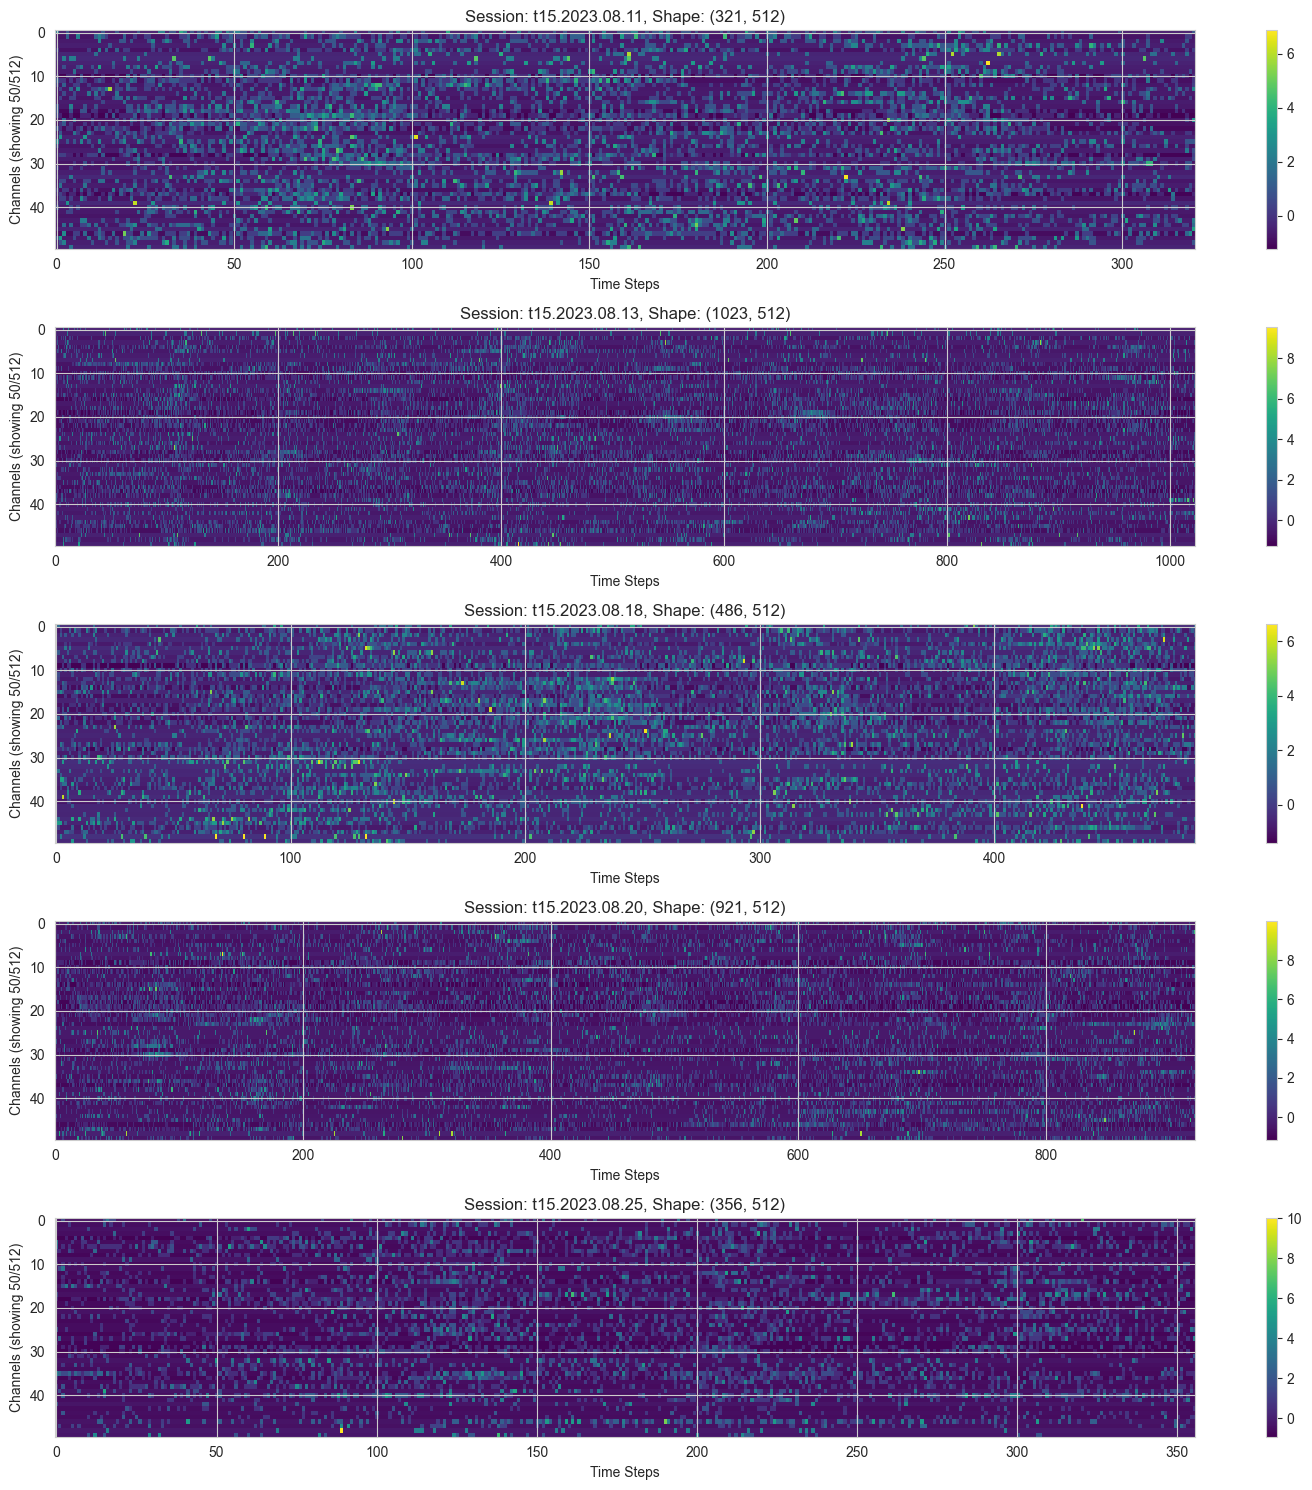

In [7]:
# Load full neural features for visualization
def load_neural_features(session_path, split='train', trial_idx=0):
    file_path = os.path.join(session_path, f"data_{split}.hdf5")
    if not os.path.exists(file_path):
        return None
    
    with h5py.File(file_path, 'r') as f:
        keys = sorted(f.keys())
        if trial_idx >= len(keys):
            return None
        key = keys[trial_idx]
        trial = f[key]
        if 'input_features' in trial:
            return trial['input_features'][:]
    return None

# Visualize sample neural features
num_samples = 5
fig, axes = plt.subplots(num_samples, 1, figsize=(15, 3*num_samples))
if num_samples == 1:
    axes = [axes]

for idx in range(num_samples):
    if idx < len(session_folders):
        neural = load_neural_features(session_folders[idx], split='train', trial_idx=0)
        if neural is not None:
            # Plot subset of channels
            n_channels_to_plot = min(50, neural.shape[1])
            im = axes[idx].imshow(neural[:, :n_channels_to_plot].T, 
                                aspect='auto', cmap='viridis', interpolation='nearest')
            axes[idx].set_xlabel('Time Steps')
            axes[idx].set_ylabel(f'Channels (showing {n_channels_to_plot}/{neural.shape[1]})')
            axes[idx].set_title(f"Session: {os.path.basename(session_folders[idx])}, Shape: {neural.shape}")
            plt.colorbar(im, ax=axes[idx])

plt.tight_layout()
plt.show()


## 6. Temporal Distributions


📊 Visualizing neural features from 5 sessions...
   Max time steps per sample: 500
   Channels to plot: 50/512
   Estimated time: ~2.5-10.0 seconds

  ✓ Loaded t15.2023.08.11: shape (321, 512) (0.00s)
  ✓ Loaded t15.2023.08.13: shape (500, 512) (0.00s)
  ✓ Loaded t15.2023.08.18: shape (486, 512) (0.00s)
  ✓ Loaded t15.2023.08.20: shape (500, 512) (0.00s)
  ✓ Loaded t15.2023.08.25: shape (356, 512) (0.00s)

⏱️  Total loading time: 0.01s
⏱️  Plotting time: 0.02s


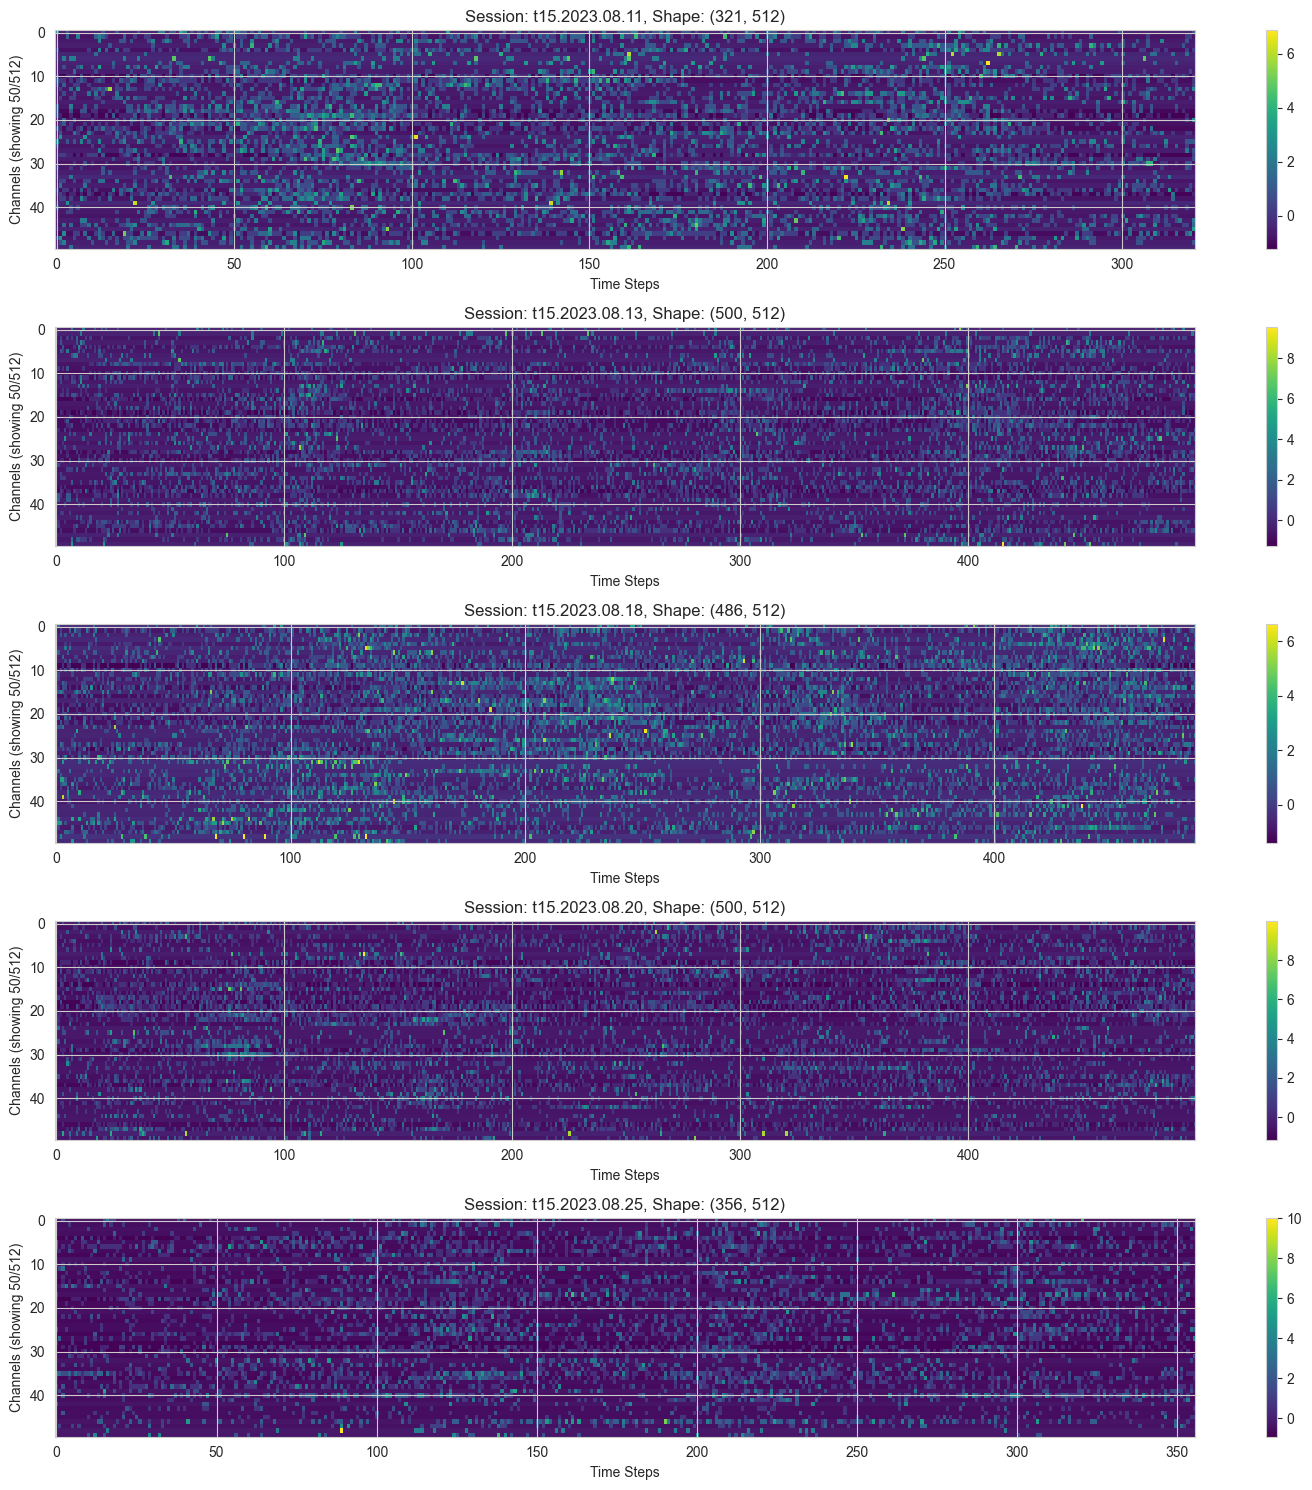


✅ Total time: 0.37s


In [ ]:
# Visualize sample neural features (with timing and progress)
import time

# Configuration
num_samples = 5  # Number of sessions to visualize
max_time_steps = 500  # Limit time steps for faster loading (set to None for full data)
n_channels_to_plot = 50  # Number of channels to show in plot

print(f"📊 Visualizing neural features from {num_samples} sessions...")
print(f"   Max time steps per sample: {max_time_steps if max_time_steps else 'all'}")
print(f"   Channels to plot: {n_channels_to_plot}/512")
print(f"   Estimated time: ~{num_samples * 0.5:.1f}-{num_samples * 2:.1f} seconds\n")

start_time = time.time()

# Load data first (with progress)
neural_data = []
session_names = []
for idx in range(min(num_samples, len(session_folders))):
    session_path = session_folders[idx]
    session_name = os.path.basename(session_path)
    
    load_start = time.time()
    neural = load_neural_features(session_path, split='train', trial_idx=0)
    load_time = time.time() - load_start
    
    if neural is not None:
        # Limit time steps if configured
        if max_time_steps and neural.shape[0] > max_time_steps:
            neural = neural[:max_time_steps, :]
        neural_data.append(neural)
        session_names.append(session_name)
        print(f"  ✓ Loaded {session_name}: shape {neural.shape} ({load_time:.2f}s)")
    else:
        print(f"  ✗ No data found for {session_name}")

total_load_time = time.time() - start_time
print(f"\n⏱️  Total loading time: {total_load_time:.2f}s")

# Create visualization only if we have data
if neural_data:
    fig, axes = plt.subplots(len(neural_data), 1, figsize=(15, 3*len(neural_data)))
    if len(neural_data) == 1:
        axes = [axes]
    
    plot_start = time.time()
    for idx, (neural, session_name) in enumerate(zip(neural_data, session_names)):
        # Plot subset of channels
        n_plot = min(n_channels_to_plot, neural.shape[1])
        im = axes[idx].imshow(neural[:, :n_plot].T, 
                            aspect='auto', cmap='viridis', interpolation='nearest')
        axes[idx].set_xlabel('Time Steps')
        axes[idx].set_ylabel(f'Channels (showing {n_plot}/{neural.shape[1]})')
        axes[idx].set_title(f"Session: {session_name}, Shape: {neural.shape}")
        plt.colorbar(im, ax=axes[idx])
    
    plot_time = time.time() - plot_start
    print(f"⏱️  Plotting time: {plot_time:.2f}s")
    
    plt.tight_layout()
    plt.show()
    
    total_time = time.time() - start_time
    print(f"\nTotal time: {total_time:.2f}s")
else:
    print("\nNo neural data found to visualize!")

## 7. Phoneme Analysis


Loading phonemes: 100%|██████████| 10/10 [00:00<00:00, 72.38it/s]

Total phonemes analyzed: 250000
Unique phoneme indices: 41

Top 20 most common phonemes:
  BLANK  (ID  0): 237368 (94.95%)
   |     (ID 40):   2953 ( 1.18%)
  T      (ID 31):    815 ( 0.33%)
  AH     (ID  3):    791 ( 0.32%)
  IH     (ID 17):    597 ( 0.24%)
  N      (ID 23):    566 ( 0.23%)
  S      (ID 29):    412 ( 0.16%)
  IY     (ID 18):    412 ( 0.16%)
  L      (ID 21):    394 ( 0.16%)
  D      (ID  9):    392 ( 0.16%)
  R      (ID 28):    377 ( 0.15%)
  K      (ID 20):    298 ( 0.12%)
  DH     (ID 10):    294 ( 0.12%)
  M      (ID 22):    289 ( 0.12%)
  AY     (ID  6):    289 ( 0.12%)
  AE     (ID  2):    277 ( 0.11%)
  UW     (ID 34):    277 ( 0.11%)
  EH     (ID 11):    265 ( 0.11%)
  Z      (ID 38):    247 ( 0.10%)
  W      (ID 36):    236 ( 0.09%)


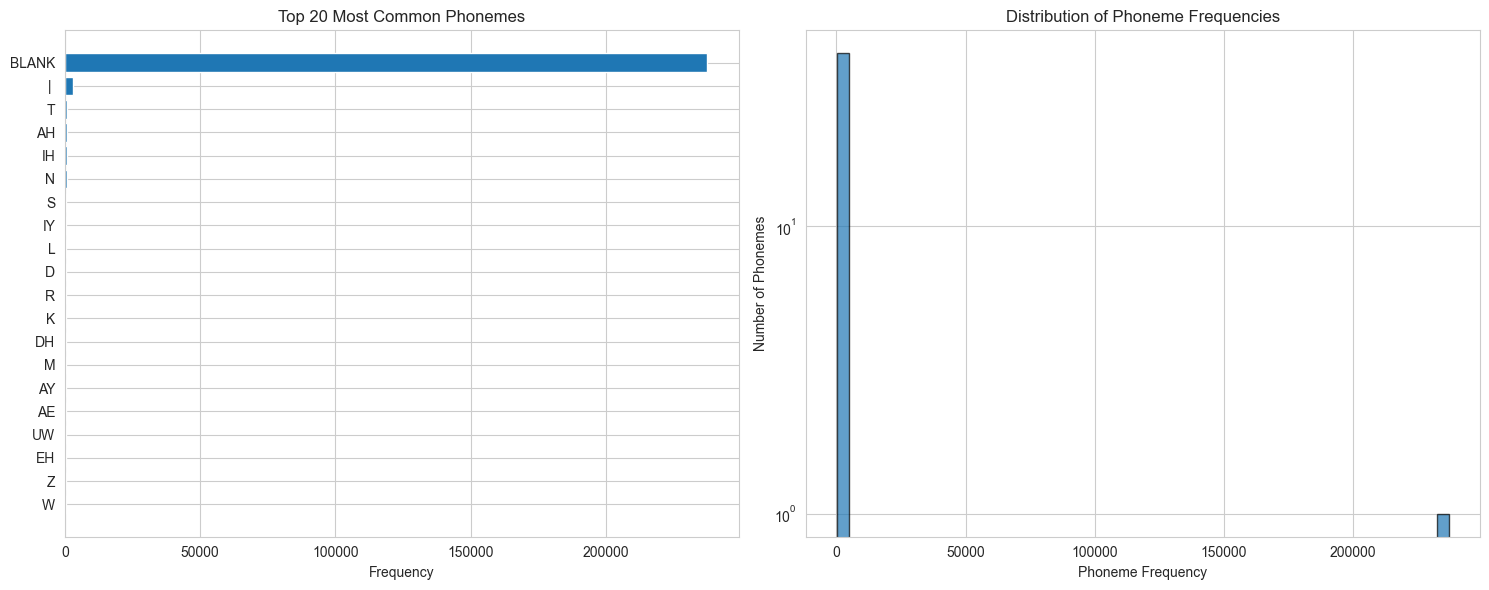

In [9]:
# Load phoneme data for analysis
def load_phonemes(session_path, split='train', max_trials=100):
    file_path = os.path.join(session_path, f"data_{split}.hdf5")
    if not os.path.exists(file_path):
        return []
    
    phonemes = []
    try:
        with h5py.File(file_path, 'r') as f:
            keys = sorted(f.keys())[:max_trials]
            for key in keys:
                trial = f[key]
                if 'seq_class_ids' in trial:
                    phonemes.extend(trial['seq_class_ids'][:].tolist())
    except:
        pass
    return phonemes

# Collect all phonemes
all_phonemes = []
sessions_to_check = session_folders[:10] if len(session_folders) > 10 else session_folders

for session_path in tqdm(sessions_to_check, desc="Loading phonemes"):
    all_phonemes.extend(load_phonemes(session_path, split='train', max_trials=50))

if all_phonemes:
    phoneme_counts = Counter(all_phonemes)
    total_phonemes = len(all_phonemes)
    
    print(f"Total phonemes analyzed: {total_phonemes}")
    print(f"Unique phoneme indices: {len(phoneme_counts)}")
    
    # Map indices to phoneme names
    id_to_phoneme = {i: phoneme for i, phoneme in enumerate(PHONEME_VOCAB)}
    
    print(f"\nTop 20 most common phonemes:")
    top_phonemes = phoneme_counts.most_common(20)
    for idx, count in top_phonemes:
        phoneme_name = id_to_phoneme.get(idx, f"ID_{idx}")
        percentage = (count / total_phonemes) * 100
        print(f"  {phoneme_name:6s} (ID {idx:2d}): {count:6d} ({percentage:5.2f}%)")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar plot of top phonemes
    top_20 = top_phonemes[:20]
    phoneme_names = [id_to_phoneme.get(idx, f"ID_{idx}") for idx, _ in top_20]
    counts = [count for _, count in top_20]
    
    axes[0].barh(range(len(phoneme_names)), counts)
    axes[0].set_yticks(range(len(phoneme_names)))
    axes[0].set_yticklabels(phoneme_names)
    axes[0].set_xlabel('Frequency')
    axes[0].set_title('Top 20 Most Common Phonemes')
    axes[0].invert_yaxis()
    
    # Distribution of all phonemes
    phoneme_values = list(phoneme_counts.values())
    axes[1].hist(phoneme_values, bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_xlabel('Phoneme Frequency')
    axes[1].set_ylabel('Number of Phonemes')
    axes[1].set_title('Distribution of Phoneme Frequencies')
    axes[1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
else:
    print("No phoneme data found")


## 8. Text Analysis


Total text samples: 4344

Sample texts:
  1. Bring it closer.
  2. My family is closer.
  3. What do they like?
  4. How is that good?
  5. Need help here?
  6. Yes, you have it right.
  7. I tell you my family is not hungry.
  8. Bring my computer here, please.
  9. They hope that.
  10. You like it?

Total words: 27524
Unique words: 3666

Top 20 most common words:
  i              :  1159
  the            :   857
  to             :   751
  a              :   689
  you            :   678
  is             :   508
  it             :   439
  of             :   418
  that           :   343
  my             :   335
  this           :   334
  have           :   330
  in             :   295
  they           :   278
  do             :   268
  are            :   256
  not            :   254
  we             :   250
  was            :   226
  what           :   225


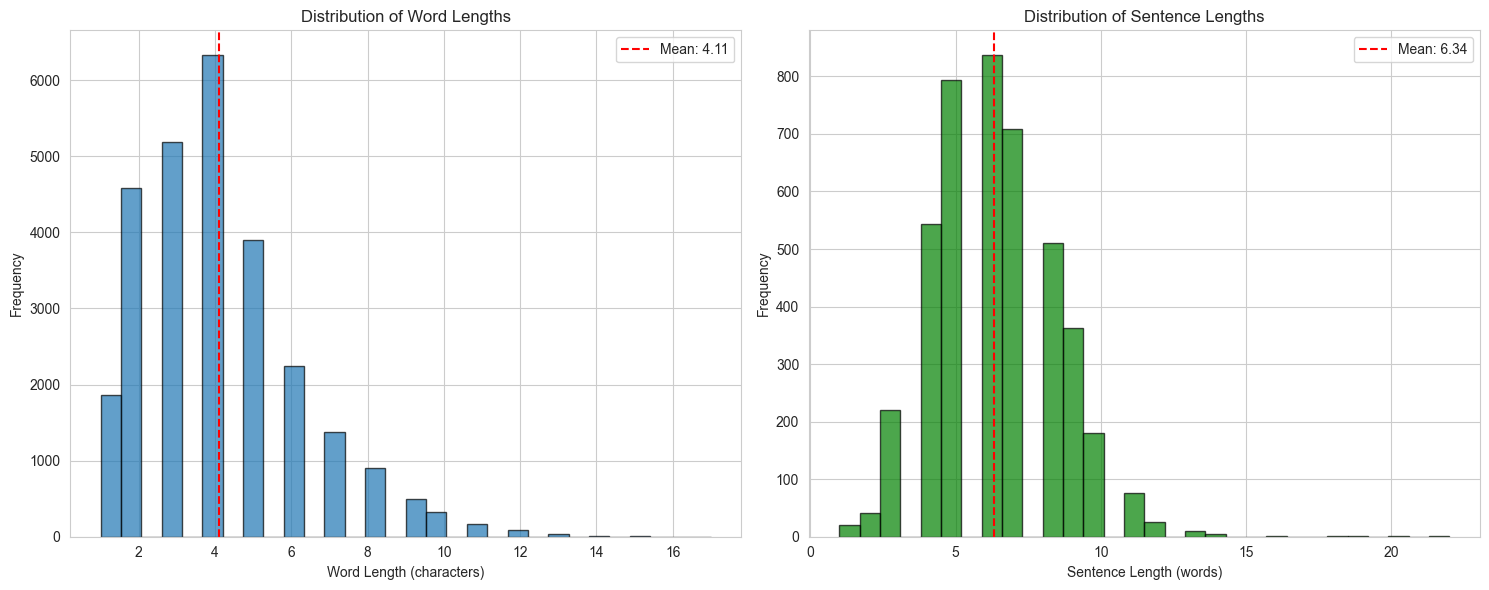

In [10]:
if train:
    texts = [t['text'] for t in train if 'text' in t]
    
    if texts:
        print(f"Total text samples: {len(texts)}")
        print(f"\nSample texts:")
        for i, text in enumerate(texts[:10]):
            print(f"  {i+1}. {text}")
        
        # Word statistics
        all_words = []
        for text in texts:
            words = text.lower().split()
            all_words.extend(words)
        
        word_counts = Counter(all_words)
        print(f"\nTotal words: {len(all_words)}")
        print(f"Unique words: {len(word_counts)}")
        print(f"\nTop 20 most common words:")
        for word, count in word_counts.most_common(20):
            print(f"  {word:15s}: {count:5d}")
        
        # Visualize
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Word length distribution
        word_lengths = [len(word) for word in all_words]
        axes[0].hist(word_lengths, bins=30, edgecolor='black', alpha=0.7)
        axes[0].set_xlabel('Word Length (characters)')
        axes[0].set_ylabel('Frequency')
        axes[0].set_title('Distribution of Word Lengths')
        axes[0].axvline(np.mean(word_lengths), color='r', linestyle='--',
                       label=f'Mean: {np.mean(word_lengths):.2f}')
        axes[0].legend()
        
        # Sentence length distribution
        sentence_lengths = [len(text.split()) for text in texts]
        axes[1].hist(sentence_lengths, bins=30, edgecolor='black', alpha=0.7, color='green')
        axes[1].set_xlabel('Sentence Length (words)')
        axes[1].set_ylabel('Frequency')
        axes[1].set_title('Distribution of Sentence Lengths')
        axes[1].axvline(np.mean(sentence_lengths), color='r', linestyle='--',
                       label=f'Mean: {np.mean(sentence_lengths):.2f}')
        axes[1].legend()
        
        plt.tight_layout()
        plt.show()
    else:
        print("No text data found")


## 9. Session Analysis


Sessions with data: 45

Trials per session (first 15):
  t15.2023.08.11: Train= 100, Val=   0, Test=   0, Total= 100
  t15.2023.08.13: Train= 100, Val=  35, Test=  35, Total= 170
  t15.2023.08.18: Train= 100, Val=  49, Test=  50, Total= 199
  t15.2023.08.20: Train= 100, Val=  48, Test=  49, Total= 197
  t15.2023.08.25: Train=  88, Val=  25, Test=  25, Total= 138
  t15.2023.08.27: Train= 100, Val=  25, Test=  25, Total= 150
  t15.2023.09.01: Train= 100, Val=  49, Test=  50, Total= 199
  t15.2023.09.03: Train= 100, Val=  34, Test=  35, Total= 169
  t15.2023.09.24: Train= 100, Val=  35, Test=  35, Total= 170
  t15.2023.09.29: Train= 100, Val=  48, Test=  49, Total= 197
  t15.2023.10.01: Train= 100, Val=  44, Test=  45, Total= 189
  t15.2023.10.06: Train= 100, Val=  36, Test=  37, Total= 173
  t15.2023.10.08: Train= 100, Val=  17, Test=  18, Total= 135
  t15.2023.10.13: Train= 100, Val=  44, Test=  45, Total= 189
  t15.2023.10.15: Train= 100, Val=  44, Test=  45, Total= 189


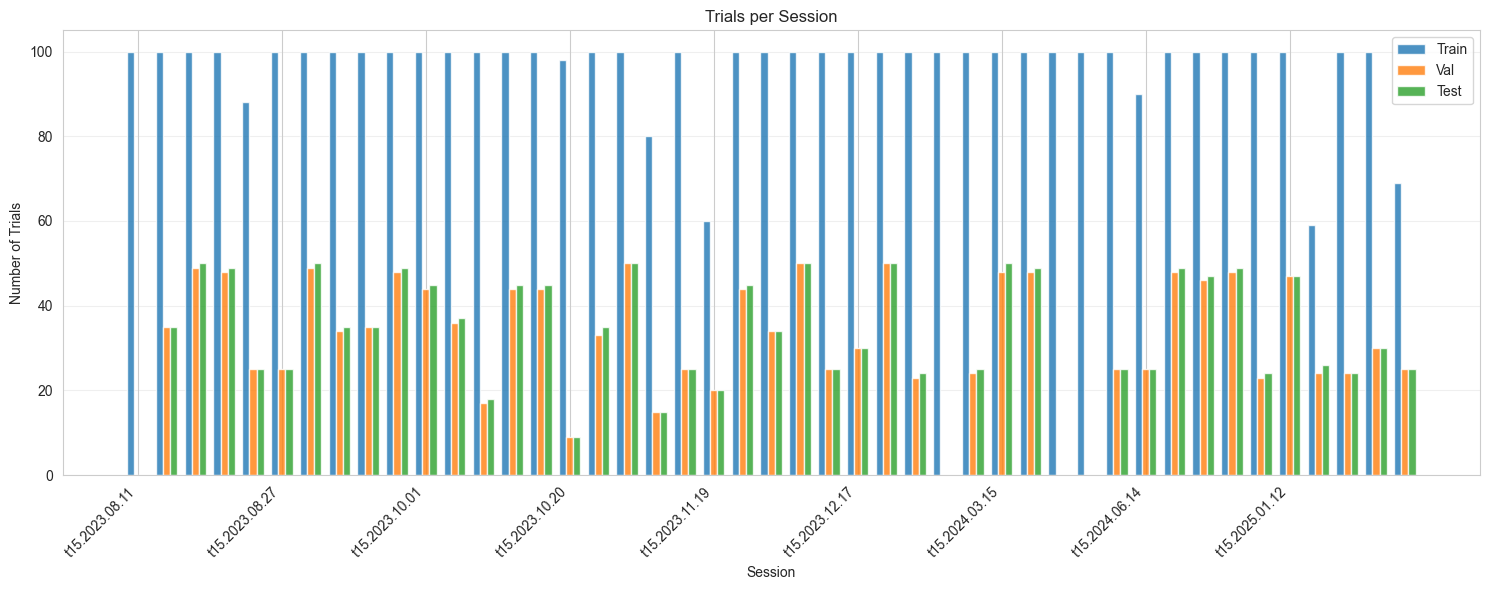

In [11]:
# Group by session
session_stats = {}
for trial in train + val + test:
    session = trial['session']
    if session not in session_stats:
        session_stats[session] = {'train': 0, 'val': 0, 'test': 0}
    session_stats[session][trial['split']] += 1

print(f"Sessions with data: {len(session_stats)}")
print(f"\nTrials per session (first 15):")
for session in sorted(session_stats.keys())[:15]:
    stats = session_stats[session]
    total = stats['train'] + stats['val'] + stats['test']
    print(f"  {session}: Train={stats['train']:4d}, Val={stats['val']:4d}, Test={stats['test']:4d}, Total={total:4d}")

# Visualize
sessions = sorted(session_stats.keys())
train_counts = [session_stats[s]['train'] for s in sessions]
val_counts = [session_stats[s]['val'] for s in sessions]
test_counts = [session_stats[s]['test'] for s in sessions]

fig, ax = plt.subplots(figsize=(15, 6))
x = np.arange(len(sessions))
width = 0.25

ax.bar(x - width, train_counts, width, label='Train', alpha=0.8)
ax.bar(x, val_counts, width, label='Val', alpha=0.8)
ax.bar(x + width, test_counts, width, label='Test', alpha=0.8)

ax.set_xlabel('Session')
ax.set_ylabel('Number of Trials')
ax.set_title('Trials per Session')
ax.set_xticks(x[::5])  # Show every 5th session
ax.set_xticklabels([sessions[i] for i in x[::5]], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## 10. Neural Feature Statistics


Loading neural features: 100%|██████████| 100/100 [00:00<00:00, 1119.86it/s]

Neural Feature Statistics (from 100 samples):
  Shape: (32100, 512)
  Mean: -0.000065
  Std: 0.999275
  Min: -2.410202
  Max: 10.000000


  Median: -0.330673

Per-Channel Statistics:
  Mean across channels - Mean: -0.000065, Std: 0.000848
  Std across channels - Mean: 0.999215, Std: 0.010473


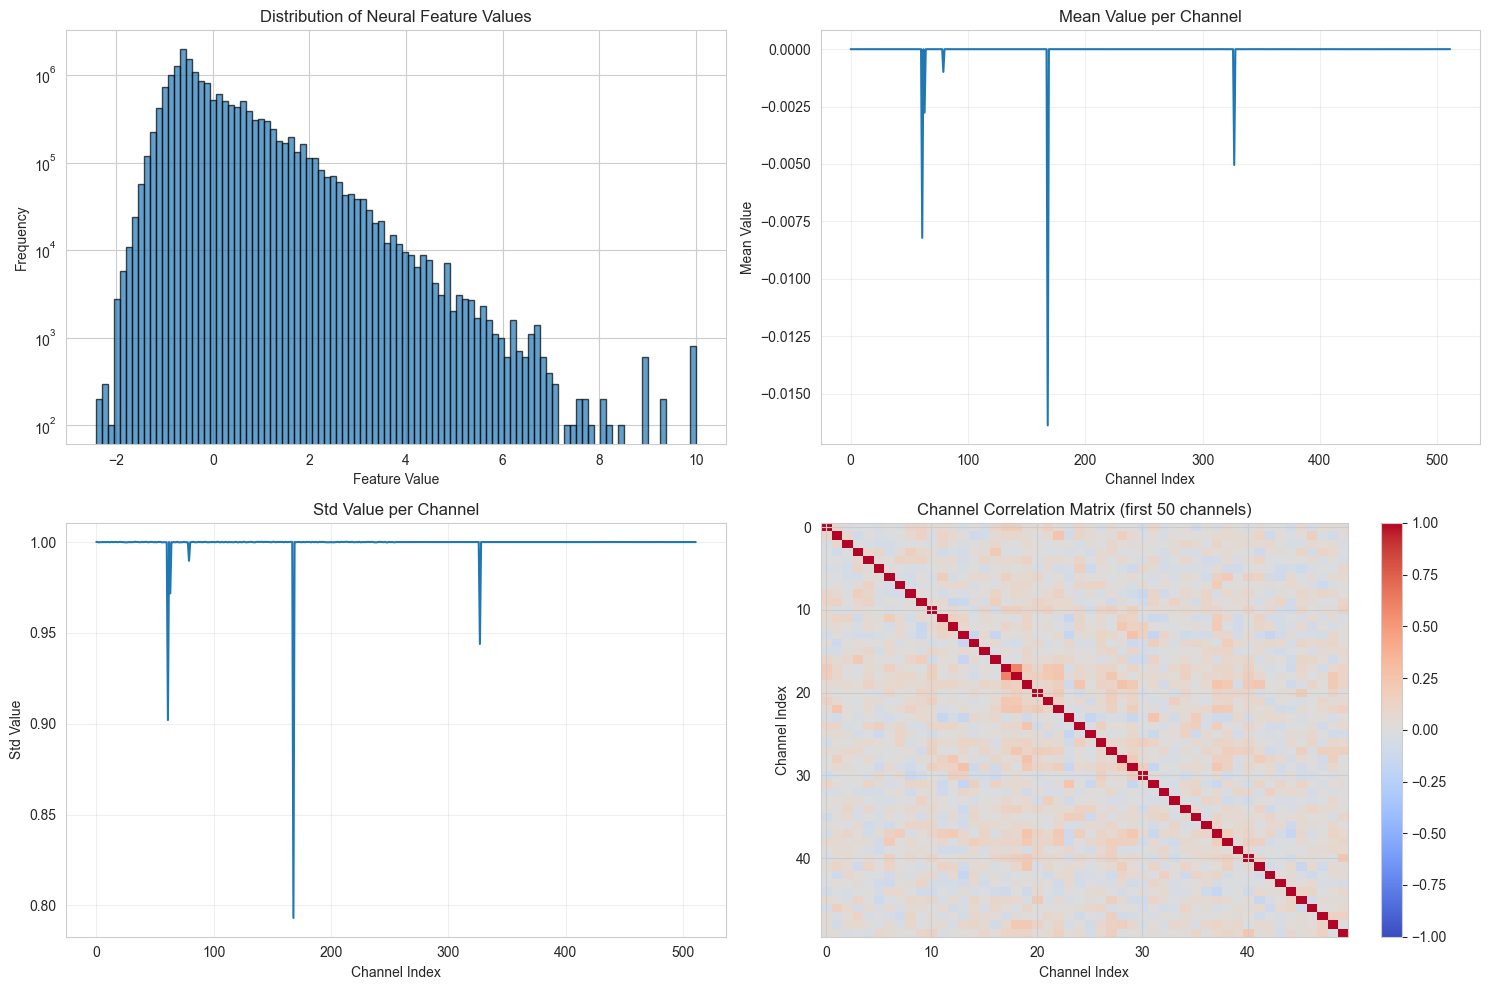

In [12]:
# Sample neural features for statistics
sample_size = min(100, len(train))
all_features = []

for trial_data in tqdm(train[:sample_size], desc="Loading neural features"):
    session_path = os.path.join(DATA_DIR, trial_data['session'])
    neural = load_neural_features(session_path, split='train', trial_idx=0)
    if neural is not None:
        all_features.append(neural)

if all_features:
    stacked = np.vstack(all_features)
    
    print(f"Neural Feature Statistics (from {len(all_features)} samples):")
    print(f"  Shape: {stacked.shape}")
    print(f"  Mean: {np.mean(stacked):.6f}")
    print(f"  Std: {np.std(stacked):.6f}")
    print(f"  Min: {np.min(stacked):.6f}")
    print(f"  Max: {np.max(stacked):.6f}")
    print(f"  Median: {np.median(stacked):.6f}")
    
    # Per-channel statistics
    channel_means = np.mean(stacked, axis=0)
    channel_stds = np.std(stacked, axis=0)
    
    print(f"\nPer-Channel Statistics:")
    print(f"  Mean across channels - Mean: {np.mean(channel_means):.6f}, Std: {np.std(channel_means):.6f}")
    print(f"  Std across channels - Mean: {np.mean(channel_stds):.6f}, Std: {np.std(channel_stds):.6f}")
    
    # Visualize
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Distribution of all feature values
    axes[0, 0].hist(stacked.flatten(), bins=100, edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Feature Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Neural Feature Values')
    axes[0, 0].set_yscale('log')
    
    # Mean per channel
    axes[0, 1].plot(channel_means)
    axes[0, 1].set_xlabel('Channel Index')
    axes[0, 1].set_ylabel('Mean Value')
    axes[0, 1].set_title('Mean Value per Channel')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Std per channel
    axes[1, 0].plot(channel_stds)
    axes[1, 0].set_xlabel('Channel Index')
    axes[1, 0].set_ylabel('Std Value')
    axes[1, 0].set_title('Std Value per Channel')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Correlation matrix (sample of channels)
    n_channels_sample = min(50, stacked.shape[1])
    corr_matrix = np.corrcoef(stacked[:, :n_channels_sample].T)
    im = axes[1, 1].imshow(corr_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
    axes[1, 1].set_xlabel('Channel Index')
    axes[1, 1].set_ylabel('Channel Index')
    axes[1, 1].set_title(f'Channel Correlation Matrix (first {n_channels_sample} channels)')
    plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
else:
    print("No neural feature data found")


---

## 📚 Data Summary - Quick Reference

<details>
<summary><b>📖 Dataset Overview (Click to expand)</b></summary>

### Dataset Structure

**Total Dataset:**
- **Sessions**: 45 sessions spanning 20 months
- **Total Sentences**: 10,948 sentences
- **Train**: ~7,500 trials (varies by session)
- **Val**: ~1,400 trials
- **Test**: 1,450 trials (no labels provided)

---

### 1. Neural Features (`input_features`)

**Shape**: `(T, 512)` per trial
- **T**: Variable time steps (typically 100-2500, mean ~891)
- **512**: Neural channels (256 electrodes × 2 feature types)

**Feature Types** (256 electrodes each):
- **Channels 0-256**: Threshold crossings (spike detection)
- **Channels 257-512**: Spike band power (activity intensity)

**Brain Regions** (64 electrodes each):
- Channels 0-64, 257-320: Ventral 6v
- Channels 65-128, 321-384: Area 4 (M1)
- Channels 129-192, 385-448: Area 55b
- Channels 193-256, 449-512: Dorsal 6v

**Temporal Resolution**: 20 ms per timestep

**Data Properties**:
- **Preprocessed**: Standardized (mean ≈ 0, std ≈ 1)
- **Range**: Typically -2.4 to 10.0 (clipped outliers)
- **Distribution**: Left-skewed (median ≈ -0.33)

**Example**: `(500, 512)` = 500 timesteps × 512 channels = 10 seconds of neural data

---

### 2. Phoneme Labels (`seq_class_ids`)

**Shape**: `(P,)` - 1D array of phoneme indices
- **P**: Variable length (typically 50-500 phonemes, mean ~500)
- **Values**: Integer indices 0-40
  - 0 = BLANK (CTC blank token)
  - 1-40 = Phoneme IDs (AA, AE, AH, ..., ZH, |)
  - 41 total classes (40 phonemes + 1 blank)

**Phoneme Vocabulary**: 40 phonemes + 1 blank + 1 silence token

**Example**: `[7, 28, 17, 24, 40, ...]` = sequence of phoneme indices

---

### 3. Text Labels (`sentence_label`)

**Shape**: String (variable length)
- **Length**: Typically 3-125 characters (mean ~31)
- **Words**: Typically 1-25 words per sentence (mean ~5-6)
- **Format**: ASCII text, lowercase

**Example**: `"bring it closer."`

---

### 4. Metadata (Attributes)

**Per Trial**:
- `session`: Session date (e.g., "t15.2023.08.13")
- `block_num`: Block number within session
- `trial_num`: Trial number within block
- `n_time_steps`: Number of neural timesteps
- `seq_len`: Number of phoneme labels

---

### Shape Relationships

**Neural → Phoneme Alignment**:
- Neural: `(T, 512)` where T ≈ 100-2500
- Phonemes: `(P,)` where P ≈ 50-500
- **Ratio**: T/P ≈ 1.5-2.0 (neural is longer due to 20ms bins)

**Phoneme → Text**:
- Phonemes: Sequence of 40 phoneme types
- Text: Variable-length word sequence
- **Many-to-one**: Multiple phonemes → one word

---

### Data Loading Example

```python
# Single trial structure:
{
    'neural_features': (500, 512),      # 500 timesteps × 512 channels
    'phoneme_indices': (250,),          # 250 phoneme labels
    'text': "bring it closer.",         # Text string
    'n_time_steps': 500,                # Neural length
    'phoneme_length': 250,              # Phoneme length
    'text_length': 17                   # Text length
}
```

---

### Key Numbers to Remember

| Data Type | Shape | Typical Range | Units |
|-----------|-------|---------------|-------|
| **Neural Features** | `(T, 512)` | T: 100-2500 | 20ms bins |
| **Phoneme Labels** | `(P,)` | P: 50-500 | Phoneme indices (0-40) |
| **Text Labels** | String | 3-125 chars | ASCII characters |
| **Sessions** | - | 45 sessions | - |
| **Total Trials** | - | ~10,948 | - |

---

### Preprocessing Status

✅ **Neural Features**: Standardized (mean=0, std=1), clipped at ±10  
✅ **Phoneme Labels**: Integer indices, ready for CTC loss  
✅ **Text Labels**: Clean ASCII, lowercase, ready for tokenization  

**Ready for training!** 🚀

</details>
